In [56]:
# Required Python packages
from datetime import date, datetime, timedelta
import calendar
import pandas as pd
import numpy as np
import itertools
import copy
from numpy.linalg import multi_dot
from scipy.stats import norm
from scipy.stats import bernoulli
from scipy.optimize import fmin_slsqp as min

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.linear_model import LassoCV
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import AlphaSelection

from scipy.interpolate import CubicSpline

import matplotlib.pyplot as plt
import math
import pickle

#Import Date opertative user defined functions
from ipynb.fs.full.user_defined_vik_functions import get_all_monthly_option_expiries, \
                                                     find_last_thurs_date_of_month, \
                                                     prev_workday_if_holiday, find_wkly_expries,\
                                                     date_of_prev_thurs

# Import dataframe naming functions 
from ipynb.fs.full.user_defined_vik_functions import get_mthly_df_name_from_expiry

#Import data loading functions
from ipynb.fs.full.user_defined_vik_functions import load_all_mthly_data

#import traded options parameters and info
from ipynb.fs.full.user_defined_vik_functions import generate_weekly_strikes, generate_mthly_strikes

#Import pricing functions
from ipynb.fs.full.user_defined_vik_functions import BSM_call_vec_with_div, BSM_put_vec_with_div

#Import implied volatility processing functions
from ipynb.fs.full.user_defined_vik_functions import generate_weekly_iv, gen_interpolated_iv

#Import Risk-free interest rate generation functions
from ipynb.fs.full.user_defined_vik_functions import generate_weekly_ir

#Import Stochatic process simulation functions
from ipynb.fs.full.user_defined_vik_functions import gbm1W_simulation, generate_covariance_from_correlation

# Import risk free interest rate function
from ipynb.fs.full.user_defined_vik_functions import get_risk_free_rate_from_exact_date


In [88]:
# Stock Index of Interest
stock_ident = "BANKNIFTY"
# stock_ident = "NIFTY"

#Static hedging performed at different moneyness regions 
#i.e. moneyness is used to select the option with nearest moneyness match
# ATM - At the Money, ITM - In the money, OTM - Out of the Money
prod_moneyness = "ATM"

#Product type to hedge: either "CE" or "PE"
prod_type = "CE"
# prod_type = "PE"

# The scope of this code is to hedge one option 
# and scope will be extended to a portfolio
no_of_assets = 1
cor_mat = [[1]]

#Path to refer data
source_path = "/home/jupyter-partha/Vikranth - Chapter 2/"
input_sub_path = "Input Data/mkt_data_covid_region/"
output_sub_path = "Output Data/"
input_data_path = source_path + input_sub_path
output_data_path = source_path + output_sub_path
output_plot_path = source_path   + "doc_outputs/training_fit/"


# Periods of interest will be a dictionary
#Key is the year, value is a list of months 1-12, 1- Jan, 2 - Feb,...12 - Dec
# For E.g., periods_of_interest = {2020: [3], 2019: [11, 12]}
# periods_of_interest = {2019: [8, 9, 10, 11, 12], 2020: [1, 2, 3, 4, 5, 6, 7]}
periods_of_interest = {2020: [3]}

#List of holidays
holidays_list = [date(2019, 3, 4), date(2019, 3, 21),\
                 date(2019, 4, 17), date(2019, 4, 19), date(2019, 4, 29),\
                 date(2019, 5, 1),\
                 date(2019, 6, 5),\
                 date(2019, 8, 12), date(2019, 8, 15),\
                 date(2019, 9, 2), date(2019, 9, 10), \
                 date(2019, 10, 2), date(2019, 10, 8), date(2019, 10, 21), date(2019, 10, 28), \
                 date(2019, 11, 12), \
                 date(2019, 12, 25), \
                 date(2020, 2, 21), \
                 date(2020, 3, 10), \
                 date(2020, 4, 2), date(2020, 4, 6), date(2020, 4, 10), date(2020,4, 14), \
                 date(2020, 5, 1), date(2020, 5, 25), \
                 date(2020, 10, 2), date(2020, 11, 16), date(2020, 11, 30), date(2020, 12, 25)]

#Simulation Parameters
no_of_paths = 5000

#Number of options
no_opt=1


In [89]:
#########################
#User-defined functions #
#########################

def generate_weekly_static_pfl_weights(no_of_paths, mthly_expiries_list, \
                                       dict_wkly_expiries_each_month, \
                                       dict_ce_wkly_strikes, dict_pe_wkly_strikes, \
                                       dict_wkly_spots, dict_wkly_iv, \
                                       prod_type, prod_moneyness, output_path, \
                                       option_type = "CE", no_of_assets=1, cor_mat=[[1]],\
                                       batch_size_divisor=10, no_of_epochs = 1000, stock_ident="BANKNIFTY"):
    ce_pfl_weights = []
    pe_pfl_weights = [] 
    cash_weights = []
    for each_month in mthly_expiries_list:
        strike = dict_mthly_strikes[each_month.strftime("%d-%b-%Y")]
        weekly_pfl_weights = []
        ce_dict = {}
        pe_dict = {}
        cash_dict = {}
        week_list = dict_wkly_expiries_each_month[each_month.strftime("%d-%b-%Y")]
        no_of_weeks = len(week_list)
        
#         for week in range(0, no_of_weeks):
        for week in range(0, 1):
            s_t = dict_wkly_spots[each_month.strftime("%d-%b-%Y")][week] 
            print(s_t)
            K = strike          
            r = np.array([dict_wkly_ir[each_month.strftime("%d-%b-%Y")][week]])
            
            if (week == no_of_weeks-1):
                sim_start_date = dict_wkly_expiries_each_month[each_month.strftime("%d-%b-%Y")][week]
                sim_end_date = each_month
            else:
                sim_start_date = dict_wkly_expiries_each_month[each_month.strftime("%d-%b-%Y")][week]
                sim_end_date = dict_wkly_expiries_each_month[each_month.strftime("%d-%b-%Y")][week + 1]
                
            df_full_iv = pd.read_csv(output_path + "A3_" + stock_ident + "_implied_vol_surface.csv")
            df_date = df_full_iv[df_full_iv['Date'] == sim_start_date.strftime("%d-%b-%Y")]
            
            option_moneyness = float(s_t/float(K))
            sim_moneyness = 1.0
            price_moneyness = option_moneyness
            
            # Vol Surface is already sorted when created in code A3 - This is just to make sure again
            df_date = df_date.sort_values(['T', 'Moneyness'], ascending=[False, True]).reset_index()
            
            # np.unique also sorts the array - we need to re-sort in descending order
            # This is required as last week has only one tenor and when filtering, we need to filter as 
            # tenor_list[0]
            
#             t_list = -np.sort(np.unique(np.array(-df_date['T'])))
            # COrrected the above bug - we need vol as of 1week for simulation.
    
            t_list = np.sort(np.unique(np.array(df_date['T'])))
            tenor_list = [str(int(round(t* 365))) + "D" for t in t_list]
            print(each_month, " Week: ", week)
            print(tenor_list)
            
            if (len(tenor_list) > 2):
                print("There are more than 2 tenors in the vol surface - Please check!")
                
            df_tenor = df_date[df_date['Tenor'] == tenor_list[0]]

            x = np.array(df_tenor["Moneyness"])
            y = np.array(df_tenor["Impl_Vol"])
            vol_list = [np.interp(sim_moneyness, x, y)]
            
            sim_stock_mat = gbm1W_simulation(no_of_paths, sim_start_date, sim_end_date, \
                                             no_of_assets, s_t, r, vol_list, cor_mat)
            
            call_strikes = np.sort(np.array(dict_ce_wkly_strikes[each_month.strftime("%d-%b-%Y")][week])).reshape(1,-1)
            put_strikes = np.sort(np.array(dict_pe_wkly_strikes[each_month.strftime("%d-%b-%Y")][week])).reshape(1,-1)
            no_of_calls = call_strikes.size
            no_of_puts = put_strikes.size
            no_ind_vars = no_of_calls + no_of_puts
                        
            stock_vec = sim_stock_mat[:, 1]
            r_f = get_risk_free_rate_from_exact_date(sim_start_date)
            dt = float((each_month - sim_end_date).days) / 365

            # Need higher tenor in the first element to avoiding tenor_list[1] as missing when 2 tenors are not available
            t_list = -np.sort(np.unique(np.array(-df_date['T'])))
            tenor_list = [str(int(round(t* 365))) + "D" for t in t_list]            
            df_tenor = df_date[df_date['Tenor'] == tenor_list[0]]

            x = np.array(df_tenor["Moneyness"])
            y = np.array(df_tenor["Impl_Vol"])
            vol_list = [np.interp(price_moneyness, x, y)]
            
            vol = vol_list[0]
                       
            opt_strike = strike

            if (option_type == "CE" and week != no_of_weeks-1):
                option_value = BSM_call_vec_with_div(stock_vec, opt_strike, r, r_f, vol, dt)
            elif (option_type == "PE" and week != no_of_weeks-1):
                option_value = BSM_put_vec_with_div(stock_vec, opt_strike, r, r_f, vol, dt) 
            elif (option_type == "CE" and week == no_of_weeks-1):
                option_value = np.maximum(stock_vec - opt_strike, 0) 
            else:
                option_value = np.maximum(opt_strike - stock_vec, 0)
    
            option_value = np.asarray(option_value)
            option_value = option_value.reshape(-1, 1) 
            
            y = option_value
            stock_vec = stock_vec.reshape(-1,1)
            x = np.concatenate((np.maximum(stock_vec-call_strikes,0), np.maximum(put_strikes-stock_vec,0)), axis=1) 
            

            
            
#             print("SKLearn Linear regression - OLS")
#             lin_model = LinearRegression().fit(x, y)
#             pfl_weights = lin_model.coef_
#             pfl_weights = pfl_weights.reshape(-1)
#             cash_weight = lin_model.intercept_
#             print("R-Square: ", lin_model.score(x,y))
#             print("Coefficients:")
#             print(pfl_weights)
#             print(cash_weight)           
            
#             print("SKLearn Linear regression - Ridge")
#             lin_model_ridge = Ridge(alpha=1.0).fit(x, y)
#             pfl_weights = lin_model_ridge.coef_
#             pfl_weights = pfl_weights.reshape(-1)
#             cash_weight = lin_model_ridge.intercept_
#             print("R-Square: ", lin_model_ridge.score(x, y))
#             print("Coefficients:")
#             print(pfl_weights)
#             print(cash_weight)
            
            
            print("SKLearn Linear regression - Lasso")
            lin_model_lasso = Lasso(alpha=1.0).fit(x, y)
            pfl_weights = lin_model_lasso.coef_
            pfl_weights = pfl_weights.reshape(-1)
            cash_weight = lin_model_lasso.intercept_
            print("R-Square: ", lin_model_lasso.score(x, y))
            print("Coefficients:")
            print(pfl_weights)
            print(cash_weight)
            
            #Validation
            # New simulation
            
            sim_stock_mat = gbm1W_simulation(no_of_paths, sim_start_date, sim_end_date, \
                                             no_of_assets, s_t, r, vol_list, cor_mat)
            
            stock_vec = sim_stock_mat[:, 1]           
            
            
            if (option_type == "CE" and week != no_of_weeks-1):
                option_value = BSM_call_vec_with_div(stock_vec, opt_strike, r, r_f, vol, dt)
            elif (option_type == "PE" and week != no_of_weeks-1):
                option_value = BSM_put_vec_with_div(stock_vec, opt_strike, r, r_f, vol, dt) 
            elif (option_type == "CE" and week == no_of_weeks-1):
                option_value = np.maximum(stock_vec - opt_strike, 0) 
            else:
                option_value = np.maximum(opt_strike - stock_vec, 0)
    
            option_value = np.asarray(option_value)
            option_value = option_value.reshape(-1, 1)
            
            stock_vec = stock_vec.reshape(-1,1)
            
            y = option_value.reshape(-1)
            x = np.concatenate((np.maximum(stock_vec-call_strikes,0), np.maximum(put_strikes-stock_vec,0)), axis=1) 
            y_hat = lin_model_lasso.predict(x)
            
        
            dict_payoff = {"Stock":stock_vec.reshape(-1), "y": y.reshape(-1), "yhat": y_hat.reshape(-1)}
            
            df_payoff = pd.DataFrame(dict_payoff)
            df_payoff.to_csv(output_plot_path  + "P4_LR_" + stock_ident + "_" + prod_moneyness + "_" + prod_type + "_training_fit.csv", index = False)

            
#          
#             #Find Optimal Alpha
#             alphas = np.array([-0.5, 0.0, 0.25, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0])
#             model = LassoCV(alphas=alphas)
#             visualizer = AlphaSelection(model)
#             visualizer.fit(x, y)
#             visualizer.show()
            
#             print("Stats Model _ OLS")
#             x = x
#             x = sm.add_constant(x)
#             lin_model2 = OLS(y,x).fit()
#             print(lin_model2.summary())
# #             print(lin_model2.params)
# #           pfl_weights = np.array(lin_model2.params).reshape(-1)
            
            
            ######################################################################################
            ### Portfolio weights of shorter term options from neural network of European options ###
            ######################################################################################
            
            # Call Pfl weights
            call_strikes = call_strikes.reshape(-1) 
            ce_dates_list = np.array([sim_start_date.strftime("%d-%b-%Y") for i in range(0, no_of_calls)]).reshape(-1)
            ce_wt_list = pfl_weights[0:no_of_calls]
            ce_dict = {"Date": ce_dates_list, "Strike": call_strikes, "Pfl_weights": ce_wt_list}
            df_ce = pd.DataFrame(ce_dict)
            ce_pfl_weights.append(df_ce)
    
            
            #Put Pfl Weights
            put_strikes = put_strikes.reshape(-1) 
            pe_dates_list = np.array([sim_start_date.strftime("%d-%b-%Y") for i in range(0, no_of_puts)]).reshape(-1)
            pe_wt_list = pfl_weights[no_of_calls:no_ind_vars]
            pe_dict = {"Date": pe_dates_list, "Strike":put_strikes, "Pfl_weights": pe_wt_list}
            df_pe = pd.DataFrame(pe_dict)
            pe_pfl_weights.append(df_pe)
            
            # Cash component
            cash_date = [sim_start_date.strftime("%d-%b-%Y")]
            cash_dict = {"Date":cash_date, "Pfl_weights":cash_weight} 
            df_cash = pd.DataFrame(cash_dict)
            cash_weights.append(df_cash)
            
            
        df_ce_pfl_weights = pd.concat(ce_pfl_weights, axis=0)
        df_pe_pfl_weights = pd.concat(pe_pfl_weights, axis=0)
        df_cash_pfl_weights = pd.concat(cash_weights, axis=0)

#         df_ce_pfl_weights.to_csv(output_path  + "B1A_LR_" + stock_ident + "_" + prod_moneyness + "_" + prod_type + "_CE_Pfl_weights.csv", index = False)
#         df_pe_pfl_weights.to_csv(output_path + "B1A_LR_" + stock_ident + "_" + prod_moneyness + "_" + prod_type + "_PE_Pfl_weights.csv", index = False)
#         df_cash_pfl_weights.to_csv(output_path  + "B1A_LR_" + stock_ident + "_" + prod_moneyness + "_" + prod_type + "_Cash_Pfl_weights.csv", index = False)
    
    return df_ce_pfl_weights, df_pe_pfl_weights, df_cash_pfl_weights

def output_strikes_hedged(prod_type, prod_moneyness, dict_mthly_strikes, stock_ident, output_path):
    list_of_dates = []
    list_of_prod_type = []
    list_of_strikes = []
    for each_month in dict_mthly_strikes.keys():
        list_of_dates.append(each_month)
        list_of_strikes.append(dict_mthly_strikes[each_month])
        list_of_prod_type.append(prod_type)
    dict_hedged_prod = {"Date":list_of_dates, "prod_type":list_of_prod_type, "Strike":list_of_strikes}
    df_hedged_prod = pd.DataFrame(dict_hedged_prod) 
#     df_hedged_prod.to_csv(output_path + "B1A_LR_" + stock_ident + "_" + prod_moneyness + "_" + prod_type + "_strikes_hedged.csv", index = False)
    return(df_hedged_prod)


In [90]:

#Find the monthly strikes of option from mkt data to find the option to be hedged
#Every month, an option is hedged
mthly_expiries_list = get_all_monthly_option_expiries(periods_of_interest, holidays_list)
dict_wkly_expiries_each_month = find_wkly_expries(mthly_expiries_list, holidays_list)

# #Load all monthly mkt data
mthly_mkt_data = load_all_mthly_data(mthly_expiries_list, input_data_path, holidays_list, prod_type_lists=["FUT", "CE", "PE"], stock_ident=stock_ident)

# #Load weekly strikes of short term options used for hedging monthly options 
dict_ce_wkly_strikes, dict_pe_wkly_strikes, dict_wkly_spots = generate_weekly_strikes(dict_wkly_expiries_each_month, input_data_path, stock_ident = stock_ident)     

#Load monthly strikes of interest as of required moneyness on the begining of month
dict_mthly_strikes = generate_mthly_strikes(mthly_mkt_data, prod_moneyness, prod_type, holidays_list, stock_ident=stock_ident)

#Load weekly IV for Black-Scholes model input and monte-carlo simulation of stock paths
dict_wkly_iv = generate_weekly_iv(dict_wkly_expiries_each_month, dict_wkly_spots, dict_mthly_strikes, prod_type, output_path=output_data_path, atm_ind=0, stock_ident=stock_ident)

#Load weekly risk free interest rates from futures
#This function to be changed based on updates on risk-free-interest - now kept it as cosntant
dict_wkly_ir = generate_weekly_ir(dict_wkly_expiries_each_month, mthly_mkt_data, stock_ident)

# # #Load Static portfolio weights built by neural network
ce_pfl_wts, pe_pfl_wts, cash_pfl_wts = generate_weekly_static_pfl_weights(no_of_paths, mthly_expiries_list, dict_wkly_expiries_each_month, \
                                                        dict_ce_wkly_strikes, dict_pe_wkly_strikes, dict_wkly_spots, \
                                                        dict_wkly_iv, prod_type, prod_moneyness, output_data_path, \
                                                        option_type = prod_type, no_of_assets=no_of_assets, \
                                                        cor_mat=cor_mat, stock_ident=stock_ident) 

# # # The strike correspnding to the option that is hedged
df_hedged_prod = output_strikes_hedged(prod_type, prod_moneyness, dict_mthly_strikes, stock_ident, output_data_path)

#nifty - 11,633.3
#banknifty - 30,187

30187.0
2020-03-26  Week:  0
['7D', '28D']
SKLearn Linear regression - Lasso
R-Square:  0.9999544224394809
Coefficients:
[ 0.59924407 -0.03947478  0.00237548  0.00857151  0.02426226  0.02671272
  0.02544649  0.02758722  0.03516435  0.04758618  0.01969365  0.
  0.13355718  0.03428027  0.0882352   0.07216028 -0.01136162  0.0308466
  0.06359164  0.01195376 -0.03249018  0.03040543  0.12339711  0.04827481
 -0.21103871 -0.30988714 -0.03838639  0.02641444  0.03434605]
[456.21853055]


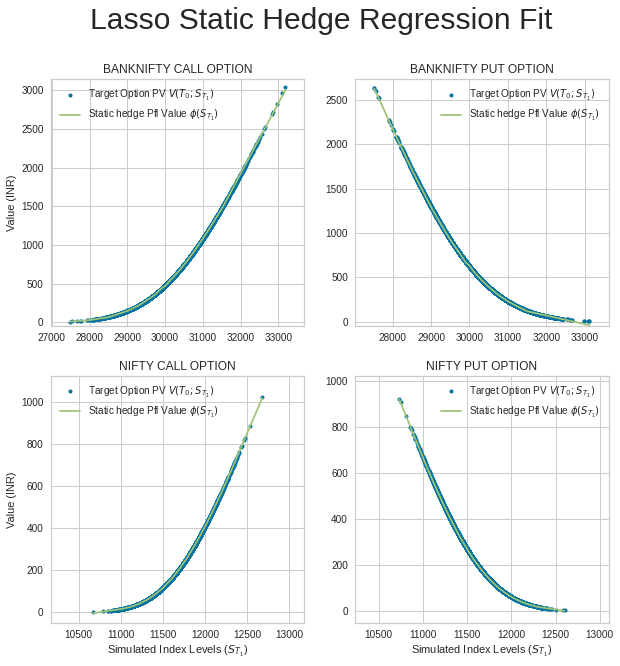

In [93]:
import matplotlib.pyplot as plt
import math
import pickle
from itertools import chain, product

fig, axs = plt.subplots(2, 2, figsize=(10,10))
fig.suptitle('Lasso Static Hedge Regression Fit', fontsize=30)
plot_data_list = ["P4_LR_BANKNIFTY_ATM_CE_training_fit.csv", "P4_LR_BANKNIFTY_ATM_PE_training_fit.csv", \
                 "P4_LR_NIFTY_ATM_CE_training_fit.csv", "P4_LR_NIFTY_ATM_PE_training_fit.csv"]
plot_names = ["BANKNIFTY CALL OPTION", "BANKNIFTY PUT OPTION", "NIFTY CALL OPTION", "NIFTY PUT OPTION"]
plot_id_list = list(product(range(0, 2), range(0, 2)))
plot_id = 0

for data in plot_data_list: 
        
        df_plot = pd.read_csv(output_plot_path + data)
        df_plot = df_plot.sort_values(["Stock"], ascending=[True]).reset_index()
        x = np.array(df_plot["Stock"])
        y = np.array(df_plot["y"]) 
        y_hat = np.array(df_plot["yhat"]) 
    
        x_min = max(np.amin(x) - 500, 0)
        x_max = np.amax(x) + 500
        y_min= max(-50, np.amin(y) - 500)
        y_max = np.amax(y) + 100

        axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].plot(x, y,'o', markersize=4, label='Target Option PV $V(T_0;S_{T_1})$')
        axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].plot(x, y_hat, '-', label='Static hedge Pfl Value $\phi(S_{T_1})$')
        axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].axis([x_min, x_max, y_min, y_max])
        axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].set_title(plot_names[plot_id])
        axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].legend()
        if (plot_id in [0,2]):
            axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].set(ylabel='Value (INR)')
        if (plot_id in [2, 3]):
            axs[plot_id_list[plot_id][0], plot_id_list[plot_id][1]].set(xlabel='Simulated Index Levels ($S_{T_1}$)')        
            
        plot_id = plot_id + 1

fig.savefig(output_plot_path + "lasso_regression_fit.png")
